In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt 
from tqdm import tqdm

from contextlib import contextmanager

import wandb
import precip
from precip.config import CONVLSTM_MODEL_CONFIG, BOUNDARY_CLASSIFICATION_LABEL, LOCAL_PRECIP_BOUNDARY_MASK
from precip.data.dataset import SwedishPrecipitationDataset, InfiniteSampler
from precip.models.conv_lstm.model import ConvLSTM, ConvLSTMCell

# wandb.init(
#     # set the wandb project where this run will be logged
#     project="precip",
#     # track hyperparameters and run metadata
#     config=CONVLSTM_MODEL_CONFIG.__dict__,
# )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
training_dataset = SwedishPrecipitationDataset(split="train", scale=True)
validation_dataset = SwedishPrecipitationDataset(split="val", scale=True)

training_sampler = InfiniteSampler(training_dataset, shuffle=True)
validation_sampler = InfiniteSampler(validation_dataset, shuffle=True)

dataloader = DataLoader(training_dataset, sampler=training_sampler, batch_size=2, num_workers=12)
val_dataloader = DataLoader(validation_dataset, sampler=validation_sampler, batch_size=2, num_workers=12)
train_dataiter, val_dataiter = iter(dataloader), ACiter(val_dataloader)

In [6]:
def npy_loader(path):
    sample = torch.from_numpy(np.load(path))
    return sample



class Model(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, num_layers, mask: torch.Tensor, upscale: float=255.0) -> None:
        super().__init__()

        self.lstm_model = ConvLSTM(
            input_channel=input_channels,
            hidden_channel=hidden_channels,
            kernel_size=kernel_size,
            num_layers=num_layers,
            batch_first=True,
            return_all_layers=False,
        )
        self.out_conv = nn.ConvTranspose2d(hidden_channels[-1], 1, kernel_size=(3, 3), padding=1)
        # self.mask = mask
        # self.upscale = upscale

    def forward(self, x):
        _, x = self.lstm_model(x)
        x = self.out_conv(x[0][0]).squeeze(1)
        # x *= self.upscale  # move from [0, 1] back to [0, 255]
        # x = x.int()
        # x = torch.where(~self.mask.to(device), x, BOUNDARY_CLASSIFICATION_LABEL)
        return x

mask = npy_loader(LOCAL_PRECIP_BOUNDARY_MASK)
model = Model(input_channels=1, hidden_channels=[64], kernel_size=(3, 3), num_layers=1, mask=mask).to(
    device
)

loss = nn.MSELoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=CONVLSTM_MODEL_CONFIG.lr,
    weight_decay=CONVLSTM_MODEL_CONFIG.weight_decay,
)
scheduler = optim.lr_scheduler.ExponentialLR(
    optimizer, gamma=CONVLSTM_MODEL_CONFIG.lr_scheduler_gamma
)


def train(number_of_batches: int = 100) -> float:
    model.train()
    loss_history = list()

    for _ in tqdm(range(number_of_batches)):
        (batch_X, batch_y) = next(train_dataiter)
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        out = model(batch_X)
        _loss = loss(out, batch_y)
        _loss.backward()
        optimizer.step()
        loss_history.append(_loss.item())

    return np.mean(loss_history)

@torch.no_grad()
def test(number_of_batches: int = 50) -> float:
    model.eval()
    validation_loss_history = list()

    for _ in tqdm(range(number_of_batches)):
        batch_X, batch_y = next(val_dataiter)
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        out = model(batch_X)
        validation_loss_history.append(loss(out, batch_y).item())
    return np.mean(validation_loss_history)





def loop():
    from pathlib import Path
    import random
    import string
    
    folder_name = Path(precip.__file__ ).parent / 'checkpoints' / '2023_08_28_'.join(random.choices(string.ascii_uppercase + string.digits, k=5)))
    folder_name.mkdir(parents=True, exist_ok=True)
    
    batch_size = 2
    training_batches_per_step = 500
    
    train_loss = list()
    val_loss = list()
    
    for step_num in range(20):
        
        number_of_observations = batch_size*training_batches_per_step*step_num
        
        t, v = train(), test()
        print(t, v)
        train_loss.append(t)
        val_loss.append(v)
        
        torch.save({
            'total_number_observations': 500,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': t,
            'val_loss': v
        }, folder_name / f'step_num_{step_num}')
        
        
    return train_loss, val_loss
        

In [12]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 0.574MB


In [7]:
train_loss, val_loss = loop()

100%|██████████| 50/50 [00:10<00:00,  4.66it/s]


5745.122053527832 535.699476928711


100%|██████████| 50/50 [00:10<00:00,  4.77it/s]


266.15434631347654 361.53385162353516


100%|██████████| 50/50 [00:10<00:00,  4.76it/s]


238.63903533935547 389.0598791503906


100%|██████████| 50/50 [00:10<00:00,  4.76it/s]


235.84532165527344 361.4779635620117


100%|██████████| 50/50 [00:10<00:00,  4.74it/s]


229.62707565307616 338.08379821777345


100%|██████████| 50/50 [00:10<00:00,  4.72it/s]


227.91693756103516 417.31300537109377


100%|██████████| 50/50 [00:10<00:00,  4.72it/s]


229.66391830444337 463.54387939453125


100%|██████████| 50/50 [00:10<00:00,  4.74it/s]


231.30777481079102 263.7325479125977


100%|██████████| 50/50 [00:10<00:00,  4.69it/s]


223.78089782714844 383.58264587402346


100%|██████████| 50/50 [00:10<00:00,  4.74it/s]


222.16931671142578 261.89396606445314


100%|██████████| 50/50 [00:10<00:00,  4.74it/s]


218.9306642150879 353.68738220214846


100%|██████████| 50/50 [00:09<00:00,  5.13it/s]


213.11923294067384 313.71123779296875


100%|██████████| 50/50 [00:09<00:00,  5.13it/s]


210.194513092041 280.6427456665039


100%|██████████| 50/50 [00:09<00:00,  5.13it/s]


206.13175552368165 349.88097198486327


100%|██████████| 50/50 [00:09<00:00,  5.08it/s]


194.72179855346678 326.0681336975098


100%|██████████| 50/50 [00:10<00:00,  4.66it/s]


198.59615051269532 397.8452195739746


100%|██████████| 50/50 [00:10<00:00,  4.63it/s]


325.30607009887694 337.730100402832


100%|██████████| 50/50 [00:10<00:00,  4.57it/s]


211.4642805480957 363.0515841674805


100%|██████████| 50/50 [00:10<00:00,  4.61it/s]


197.3426628112793 394.045277557373


100%|██████████| 50/50 [00:10<00:00,  4.55it/s]

188.9892205810547 394.89374099731447


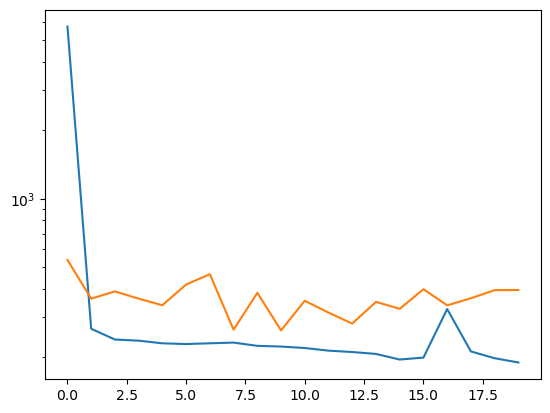

In [11]:
plt.semilogy(train_loss)
plt.semilogy(val_loss)